In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Cleaning & Splitting dataset (fatalities & confirmed infected)

In [2]:
train_data = pd.read_csv('data/train.csv')
print(len(train_data))
# discovered negative numbers, hence fixing negative numbers
train_data['TargetValue'] = train_data['TargetValue'].abs()
# checking null values for Province_State
train_data = train_data[train_data.Province_State.isnull()]
train_data = train_data[['Country_Region', 'Population', 'Weight', 'Date', 'Target', 'TargetValue']]
print(len(train_data))

914232
49368


In [3]:
nb_countries = len(set(train_data['Country_Region']))
print(f'In this dataset {nb_countries} countries are included.')

In this dataset 187 countries are included.


## Data Enrichment

In [4]:
extra_df = pd.read_csv('data/population_by_country_2020.csv')

In [5]:
extra_df.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1438207241,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1377233523,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,330610570,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,272931713,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,219992900,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [6]:
columns = ['Country (or dependency)', 'Density (P/Km²)', 'Med. Age', 'Urban Pop %']
extra_df = extra_df[columns]
extra_df = extra_df.rename(columns={'Country (or dependency)':'Country_Region'})

In [7]:
alter_country = {'Congo (Kinshasa)':'DR Congo','Congo (Brazzaville)':'Congo','Burma':'Myanmar','Taiwan*': 'Taiwan', 'US': 'United States', 'Czechia':'Czech Republic (Czechia)', 'Korea, South':'South Korea', 'Saint Kitts and Nevis':'Saint Kitts & Nevis', 'Sao Tome and Principe':'Sao Tome & Principe'}

In [8]:
train_data['Country_Region']=train_data['Country_Region'].map(alter_country).fillna(train_data['Country_Region'])

In [9]:
extra_df['Urban Pop %'] = extra_df['Urban Pop %'].str.rstrip(' %')

extra_df['Urban Pop %'] = extra_df['Urban Pop %'].replace({'N.A.':0})

extra_df['Urban Pop %'] = extra_df['Urban Pop %'].astype(float)

In [10]:
extra_data = [{'Country_Region':'Kosovo','Density (P/Km²)':159, 'Med. Age':29.1, 'Urban Pop %':54.7},
             {'Country_Region':'West Bank and Gaza','Density (P/Km²)':826, 'Med. Age':21.4, 'Urban Pop %':76.17},
             {'Country_Region':'Saint Vincent and the Grenadines','Density (P/Km²)':284, 'Med. Age':32.9, 'Urban Pop %':52.9},
             {'Country_Region':"Cote d'Ivoire" ,'Density (P/Km²)':64, 'Med. Age':18.9, 'Urban Pop %':50.78}
             ]

extra_df = extra_df.append(extra_data, ignore_index=True)

In [11]:
extra_df['Med. Age']= extra_df['Med. Age'].replace({'N.A.':np.nan})
med = extra_df['Med. Age'].median(skipna=True)
extra_df['Med. Age']= extra_df['Med. Age'].replace({np.nan:med})

In [12]:
full_data = pd.merge(train_data, extra_df, on='Country_Region')

In [13]:
cc_data = full_data[full_data['Target']=='ConfirmedCases'][['Country_Region', 'Population','Weight', 'Date','TargetValue', 'Med. Age', 'Density (P/Km²)','Urban Pop %']]
f_data = full_data[full_data['Target']=='Fatalities'][['Country_Region', 'Population','Weight', 'Date','TargetValue', 'Med. Age', 'Density (P/Km²)','Urban Pop %']]


In [14]:
grouped_cc = cc_data.groupby(['Country_Region', 'Date'])
# drop target value == 0 
grouped_cc = grouped_cc.apply(lambda x: x[x['TargetValue']>0]).reset_index(drop=True)
first_infections = grouped_cc.groupby('Country_Region').nth(0)
first_occ= dict(first_infections['Date'].value_counts().sort_index(ascending=True))
first_infect = dict(first_infections['Date'])

In [15]:
## extracting more info from dates
cc_data['Week'] = pd.to_datetime(cc_data['Date']).dt.week
cc_data['Day'] =  pd.to_datetime(cc_data['Date']).dt.day
cc_data['Weekday'] = pd.to_datetime(cc_data['Date']).dt.dayofweek

cc_data['first_infection'] = cc_data['Country_Region'].map(first_infect)
cc_data[['Date','first_infection']] = cc_data[['Date','first_infection']].apply(pd.to_datetime) 
cc_data['days_since_1st_infect'] = (cc_data['Date'] - cc_data['first_infection']).dt.days

In [16]:
f_data['Week'] = pd.to_datetime(f_data['Date']).dt.week
f_data['Day'] =  pd.to_datetime(f_data['Date']).dt.day
f_data['Weekday'] = pd.to_datetime(f_data['Date']).dt.dayofweek

f_data['first_infection'] = f_data['Country_Region'].map(first_infect)
f_data[['Date','first_infection']] = f_data[['Date','first_infection']].apply(pd.to_datetime) 
f_data['days_since_1st_infect'] = (f_data['Date'] - f_data['first_infection']).dt.days

## Some visualizations

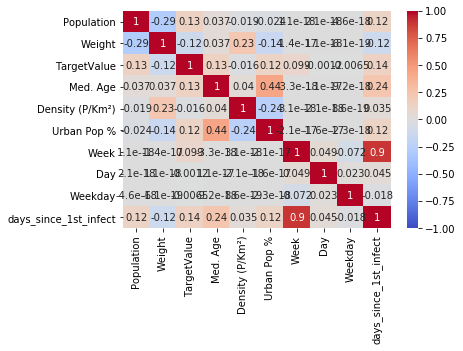

In [17]:
import seaborn as sns


sns.heatmap(f_data.corr(), xticklabels=True, yticklabels=True, vmin=-1, vmax=1, cmap='coolwarm', annot=True)#, mask = mat)

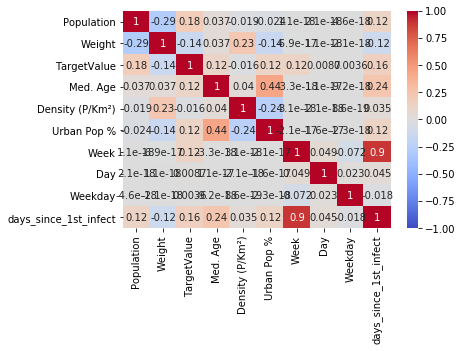

In [18]:
sns.heatmap(cc_data.corr(), xticklabels=True, yticklabels=True, vmin=-1, vmax=1, cmap='coolwarm', annot=True)#, mask = mat)

In [19]:
cc_data.head()

,Country_Region,Population,Weight,Date,TargetValue,Med. Age,Density (P/Km²),Urban Pop %,Week,Day,Weekday,first_infection,days_since_1st_infect
0,Afghanistan,27657145,0.058359,2020-01-23,0.0,18.0,60,25.0,4,23,3,2020-02-24,-32
2,Afghanistan,27657145,0.058359,2020-01-24,0.0,18.0,60,25.0,4,24,4,2020-02-24,-31
4,Afghanistan,27657145,0.058359,2020-01-25,0.0,18.0,60,25.0,4,25,5,2020-02-24,-30
6,Afghanistan,27657145,0.058359,2020-01-26,0.0,18.0,60,25.0,4,26,6,2020-02-24,-29
8,Afghanistan,27657145,0.058359,2020-01-27,0.0,18.0,60,25.0,5,27,0,2020-02-24,-28


In [20]:
cc_data.to_csv("data/cleaned_confirmed_cases.csv")

In [21]:
f_data.head()

,Country_Region,Population,Weight,Date,TargetValue,Med. Age,Density (P/Km²),Urban Pop %,Week,Day,Weekday,first_infection,days_since_1st_infect
1,Afghanistan,27657145,0.583587,2020-01-23,0.0,18.0,60,25.0,4,23,3,2020-02-24,-32
3,Afghanistan,27657145,0.583587,2020-01-24,0.0,18.0,60,25.0,4,24,4,2020-02-24,-31
5,Afghanistan,27657145,0.583587,2020-01-25,0.0,18.0,60,25.0,4,25,5,2020-02-24,-30
7,Afghanistan,27657145,0.583587,2020-01-26,0.0,18.0,60,25.0,4,26,6,2020-02-24,-29
9,Afghanistan,27657145,0.583587,2020-01-27,0.0,18.0,60,25.0,5,27,0,2020-02-24,-28


In [22]:
f_data.to_csv("data/cleaned_fatalities.csv")